In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from kaggle_hm.config import train_dates, test_dates, data_root
from kaggle_hm.utils import init_nb, plot_item, visualize_items
import numpy as np
import json
from kaggle_hm.evaluation import compute_precision, enrich_data, plot_precision_at_k, plot_precision_at_k_segments, precision_by_age, precision_by_usage
from tqdm import tqdm

init_nb()

In [2]:
print(data_root)

/data/sstamenov/kaggle-data


Cosine similarity on items works nicely.
There are very few items with very high similarity >= .4. which are usually bought together.

Items with similarity >.1 provide reasonable similarity to customer's items and are OK to be recommended.
Items had to have at least 10 customers that bought both items to be considered a candidate.

Similarity rec. system looks at items that user bought in the past, finds all items that are similar to it and appends to the candidate list.
Then the list is sorted by similarity and first 12 items are returned. If there are not enough items, the rest is filled with top items.

KNN recs provide marginal improvement over top-12 or top-12 by age group category and reach 0.0041 on public leaderboard.
They provide more consistent precision over age groups, but provide worse precision for customers with high number of purchased items.

In [2]:
customers = pd.read_parquet(data_root / 'clean/customers.parquet').set_index('customer_id')
customers['age_group'] = pd.cut(customers['age'], bins=[16, 21, 26, 30, 40, 50, 60, 100])
items = pd.read_parquet(data_root / 'clean/articles.parquet')
t = pd.read_parquet(data_root / 'clean/transactions.parquet')

In [3]:
_ = (
    (t['t_dat'] >= test_dates['start']) &
    (t['t_dat'] <= test_dates['end'])
)
test = t[_]

In [5]:
customers.shape

(1371980, 7)

In [6]:
items.shape

(105542, 25)

In [7]:
t['customer_id'].nunique()

1362281

In [8]:
t['article_id'].nunique()

104547

In [4]:
from typing import List


def pad_rec(recommended: List, top_items):
    try:
        if np.isnan(recommended):
            recommended = []
    except:
        pass
    n = len(recommended)
    if n >= 12:
        return recommended
    while n < 12:
        if top_items[0] not in recommended:
            recommended.append(top_items[0])
        top_items.pop(0)
        n = len(recommended)
    return recommended

In [10]:
pad_rec([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [11]:
pad_rec([1, 2, 4], [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [5]:
similarity_df = pd.read_parquet(data_root / 'clean' / 'similarity_table.parquet').query('len_a >= 50 and len_b >= 50')

In [6]:
similarity_df['k'] = similarity_df.groupby('a')['simil'].rank(method='first', ascending=False)

In [9]:
similarity_df.query('k <= 5').shape

(39630, 7)

# Knn predictions

In [10]:
_ = (
    (t['t_dat'] >= '2020-08-12') &
    (t['t_dat'] <= train_dates['end'])
)
train = t[_]

In [11]:
train.shape

(1069693, 5)

In [12]:
top12 = (
    train
    .groupby('article_id')
    .agg(total_count=('customer_id', 'count'))
    .sort_values('total_count', ascending=False).reset_index()[:24]['article_id'].tolist()
)

In [13]:
# ground truth
test_items = test.groupby('customer_id', observed=True).agg(bought=('article_id', set)).reset_index()

In [ ]:
# product_code is the same 5 +
# perceived_master_color is the same 1-2 +  ? perceived_colour_value_name
# both index-name Sport 2-3 +
# product_group_name Garment Lower body / Garment Upper body 1-2
# both product_group_name = Swimwear 2-3
# both product_group_name = Underwear 2-3

In [48]:
similarity_df = (
    similarity_df
    .merge(items[['article_id', 'perceived_colour_master_name', 'index_name', 'product_group_name', 'product_type_name']], left_on='a', right_on='article_id')
    .merge(items[['article_id', 'perceived_colour_master_name', 'index_name', 'product_group_name', 'product_type_name']], left_on='b', right_on='article_id', suffixes=('_a', '_b'))
    .drop(columns=['article_id_a', 'article_id_b'])
)

In [49]:
similarity_df['same_prod'] = (similarity_df['a'].str[:7] == similarity_df['b'].str[:7]).astype('int') * 1
similarity_df['same_color'] = (similarity_df['perceived_colour_master_name_a'] == similarity_df['perceived_colour_master_name_b']).astype('int') * 1
similarity_df['same_prod_type'] = (similarity_df['product_type_name_a'] == similarity_df['product_type_name_b']).astype('int') * 1
similarity_df['both_sport'] = ((similarity_df['index_name_a'] == 'Sport') & (similarity_df['index_name_b'] == 'Sport')).astype('int') * 1
similarity_df['both_swim'] = ((similarity_df['product_group_name_a'] == 'Swimwear') & (similarity_df['product_group_name_a'] == 'Swimwear')).astype('int') * 1
similarity_df['both_under'] = ((similarity_df['product_group_name_a'] == 'Underwear') & (similarity_df['product_group_name_a'] == 'Underwear')).astype('int') * 1

similarity_df['top_bottom_pair'] = (
    ((similarity_df['product_group_name_a'] == 'Garment Lower body') & (similarity_df['product_group_name_b'] == 'Garment Upper body')) |
    ((similarity_df['product_group_name_b'] == 'Garment Lower body') & (similarity_df['product_group_name_a'] == 'Garment Upper body'))
).astype('int') * 1

def len_score(len_common):
    if len_common < 10:
        return 1
    if len_common < 50:
        return 2
    if len_common < 100:
        return 3
    return 4

similarity_df['len_score'] = similarity_df['len_common'].apply(len_score)
similarity_df['match_score'] = similarity_df[['same_prod', 'same_color', 'both_sport', 'both_swim', 'both_under', 'len_score', 'same_prod_type', 'top_bottom_pair']].sum(axis=1)

In [14]:
def knn_candidates(data, similarity_df, max_candidates=12):
    nodup = data[['customer_id', 'article_id']].drop_duplicates()
    print('#item-customer pairs', nodup.shape)

    m = nodup.merge(similarity_df, left_on='article_id', right_on='a')
    print('#similar items', m.shape)

    # exclude rec items that customer already has
    _ = m.merge(nodup, left_on=['customer_id', 'b'], right_on=['customer_id', 'article_id'], how='outer')

    # deduplicate candidates
    # _ = _[_['article_id_y'].isna()].groupby(['customer_id', 'b'], observed=True).agg(simil=('simil', 'max'), len_common=('len_common', 'max'), cnt=('len_common', 'count')).reset_index()
    # HMMM?
    _ = _[_['article_id_y'].isna()]
    _['r'] = _.groupby(['customer_id', 'b'], observed=True)['simil'].rank(method='first', ascending=False)
    _ = _[_['r'] == 1]
    print('#similar items excluding already bought', _.shape)
    _['r'] = _.groupby('customer_id')['simil'].rank(method='first', ascending=False)

    # leave up to 12 most similar items
    candidates = _[_['r'] <= max_candidates]
    return candidates


def get_knn_recs(data, similarity_df, top12, test_items):
    candidates = knn_candidates(data, similarity_df)

    preds = candidates.sort_values(['customer_id', 'r']).groupby('customer_id',  observed=True).agg(recs=('b', list)).reset_index()

    preds['prediction'] = preds['recs'].apply(lambda recs: pad_rec(recs.copy(), top12.copy()))

    # test_items -> replace with submission
    results = test_items.merge(preds, on='customer_id', how='left')
    
    # fill cold-start users 
    f = results['prediction'].isna()
    results.loc[f, 'prediction'] = results.loc[f, 'prediction'].apply(lambda _: top12[:12])
    
    return results

In [15]:
results = get_knn_recs(train, similarity_df.query('k <= 5')[['a', 'b', 'simil']], top12, test_items).set_index('customer_id')

#item-customer pairs (949748, 2)
#similar items (7539931, 5)
#similar items excluding already bought (6432298, 7)


In [16]:
results = compute_precision(results)

In [17]:
results['precision'].mean()

0.010183857758659222

In [18]:
from kaggle_hm.chart_model import filter_data

In [20]:
results = enrich_data(filter_data(t, to_date='2020-09-08'), results, customers)

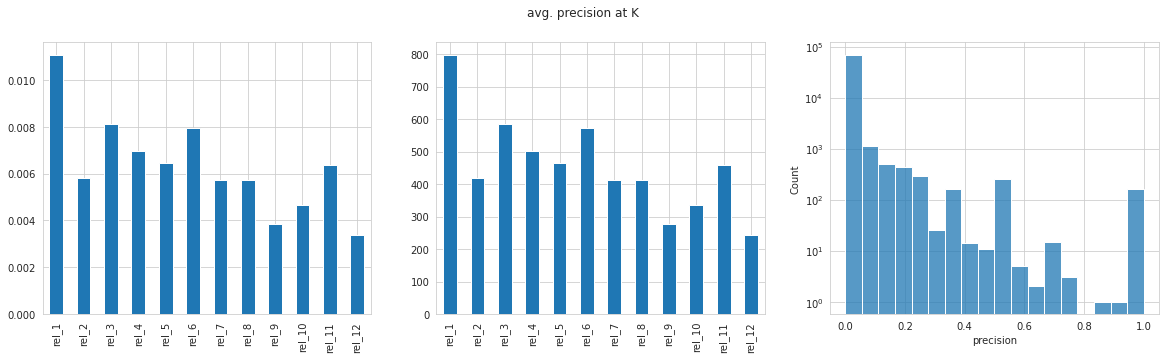

In [22]:
plot_precision_at_k(results);

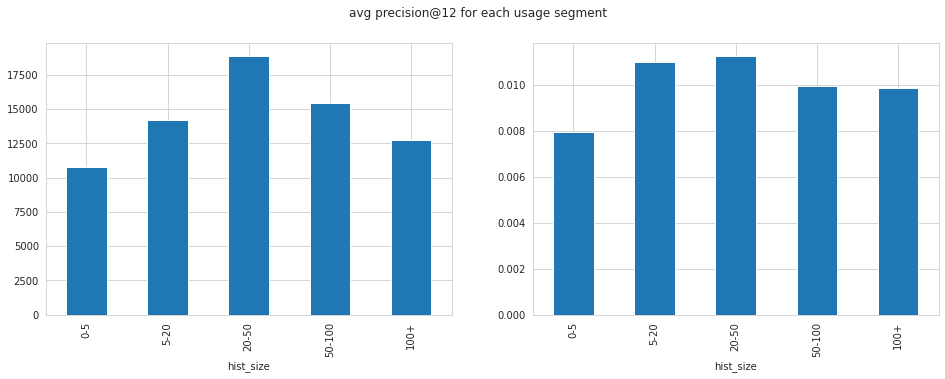

In [23]:
precision_by_usage(results);

In [120]:
(~results['recs'].isna()).sum(), results.shape[0]

(37089, 72019)

In [121]:
cols = [f'rel_{i + 1}' for i in range(12)]

In [144]:
# first 1-2 places are good KNN candidates
pd.DataFrame({
    'total': results[cols].mean(),
    'knn': results[~results['recs'].isna()][cols].mean(),
    'total-s': results[cols].sum(),
    'knn-s': results[~results['recs'].isna()][cols].sum()
})

,total,knn,total-s,knn-s
rel_1,0.0111,0.0156,796,489
rel_2,0.0058,0.0123,420,385
rel_3,0.0081,0.0114,586,356
rel_4,0.0070,0.0090,501,282
rel_5,0.0064,0.0081,464,255
rel_6,0.0079,0.0076,572,238
rel_7,0.0057,0.0067,412,210
rel_8,0.0057,0.0061,412,191
rel_9,0.0039,0.0057,279,177
rel_10,0.0047,0.0040,337,125


In [51]:
nodup = test.drop_duplicates(subset=['customer_id', 'article_id'])
t_nodup = train.drop_duplicates(subset=['customer_id', 'article_id'])

In [52]:
ext = nodup.merge(similarity_df, left_on='article_id', right_on='a', how='left')
_ = ext.merge(t_nodup, left_on=['customer_id', 'b'], right_on=['customer_id', 'article_id'])

In [53]:
_['delta'] = pd.to_datetime('2020-09-08') - _['t_dat_y']
_['decay'] = 1 / (1 + _['delta'].dt.days.describe())
_['len_sqrt'] = np.sqrt(_['len_common'])
_['days'] = _['delta'].dt.days

In [56]:
pd.DataFrame({
    'bought-pairs': _[['same_prod', 'same_color', 'both_sport', 'both_swim', 'both_under', 'top_bottom_pair', 'same_prod_type']].mean(),
    'similarity-table': similarity_df.query('len_a >= 100 and len_b >= 100')[['same_prod', 'same_color', 'both_sport', 'both_swim', 'both_under', 'top_bottom_pair', 'same_prod_type']].mean()
})

,bought-pairs,similarity-table
same_prod,0.0710,0.0303
same_color,0.3263,0.2765
both_sport,0.0554,0.0381
both_swim,0.0256,0.1227
both_under,0.0626,0.0785
top_bottom_pair,0.2166,0.1682
same_prod_type,0.2702,0.2787


In [59]:
top_pairs = _.groupby(['a', 'b']).agg(cnt=('customer_id', 'count'), mean_delta=('days', 'mean')).reset_index()

top_pairs = top_pairs.merge(similarity_df, on=['a', 'b'])

In [61]:
top_pairs['cnt'].describe()

count   66639.0000
mean        1.3217
std         0.8369
min         1.0000
25%         1.0000
50%         1.0000
75%         1.0000
max        25.0000
Name: cnt, dtype: float64

In [145]:
top_pairs.shape

(66639, 25)

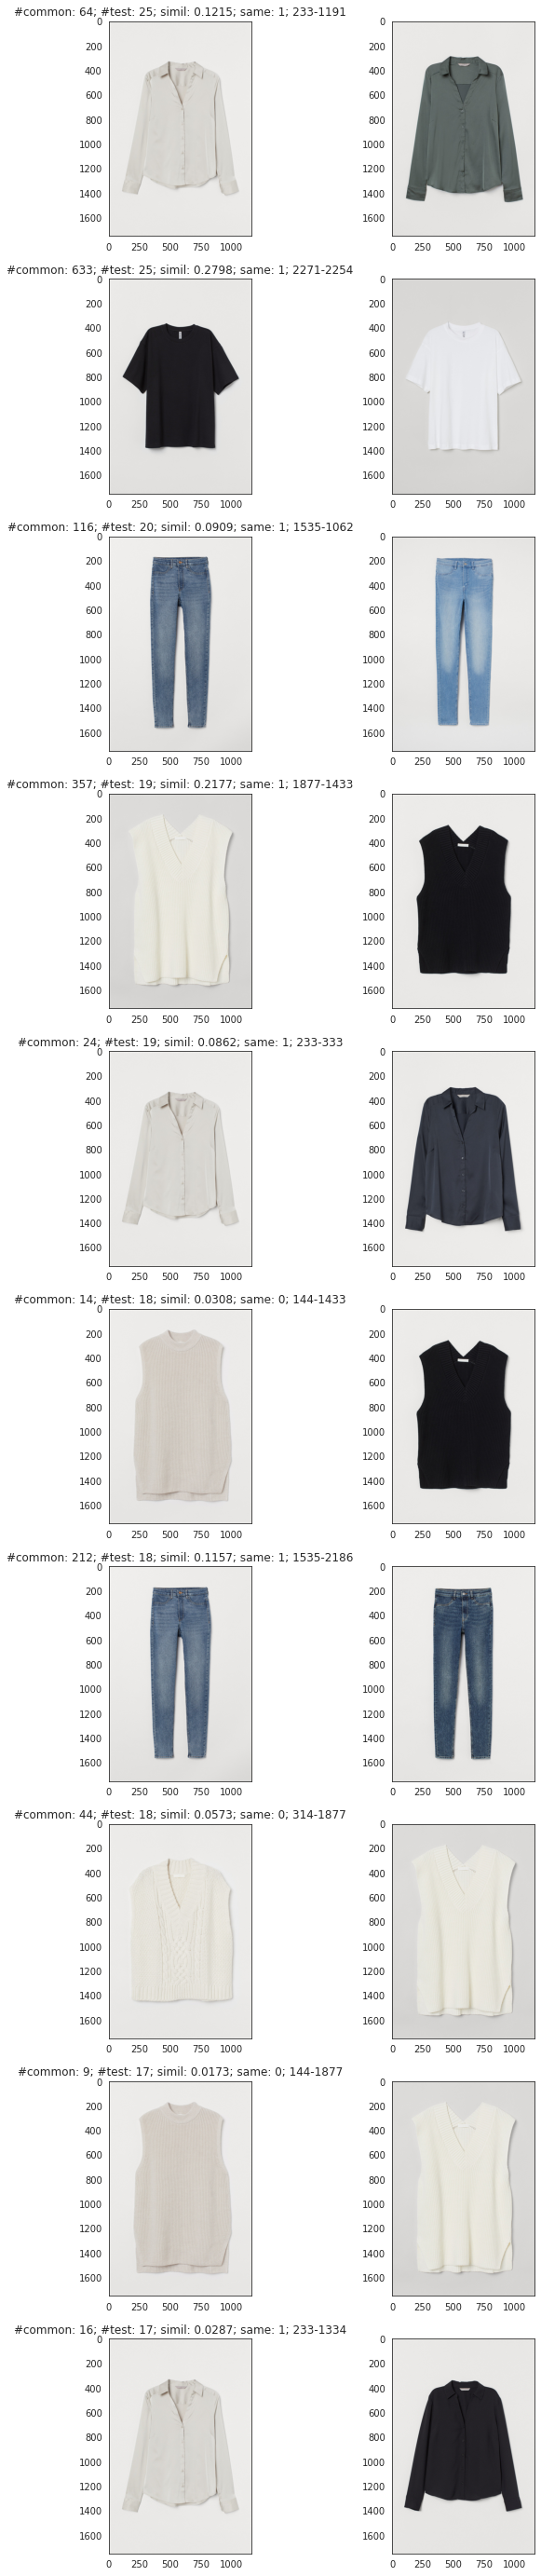

In [74]:
pairs_to_plot = top_pairs.sort_values('cnt', ascending=False).head(20)
fig, ax = plt.subplots(10, 2, figsize=(10, 50))

for i in range(10):
    row = pairs_to_plot.iloc[i]
    plot_item(row['a'], ax=ax[i, 0])
    plot_item(row['b'], ax=ax[i, 1])
    ax[i, 0].set(title='#common: {len_common}; #test: {cnt}; simil: {simil:.4f}; same: {same_prod}; {len_a}-{len_b}'.format(**row))

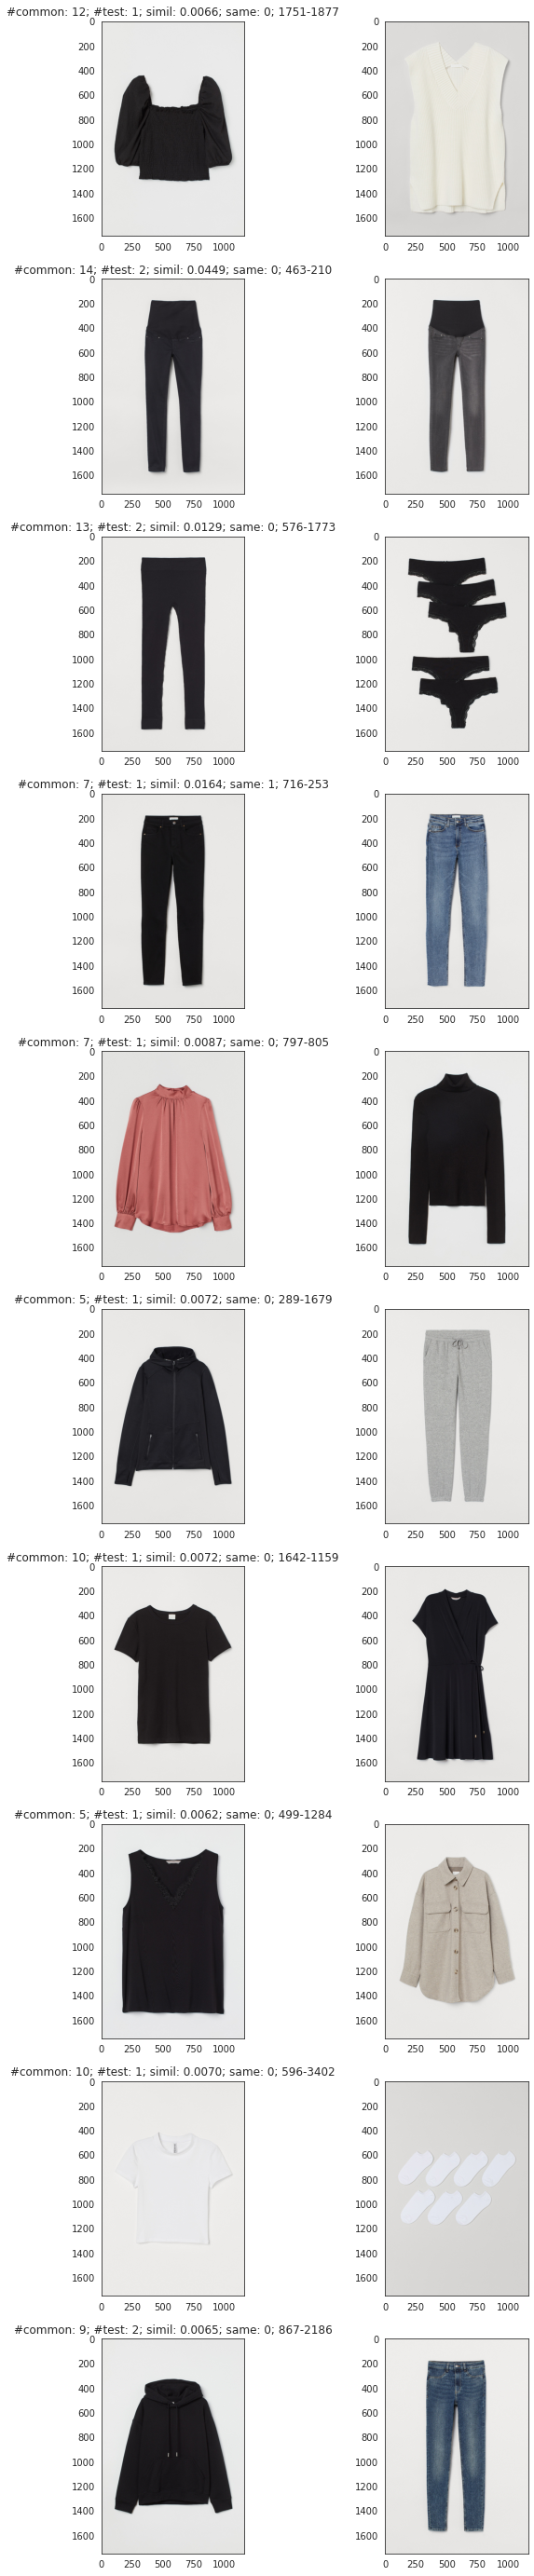

In [146]:
pairs_to_plot = top_pairs.sample(n=20)
fig, ax = plt.subplots(10, 2, figsize=(10, 50))

for i in range(10):
    row = pairs_to_plot.iloc[i]
    plot_item(row['a'], ax=ax[i, 0])
    plot_item(row['b'], ax=ax[i, 1])
    ax[i, 0].set(title='#common: {len_common}; #test: {cnt}; simil: {simil:.4f}; same: {same_prod}; {len_a}-{len_b}'.format(**row))

In [13]:
test_sales = test.groupby('article_id', observed=True).agg(test_cnt=('customer_id', 'count')).reset_index()
train_sales = train.groupby('article_id', observed=True).agg(train_cnt=('customer_id', 'count')).reset_index()

In [30]:
m = test_sales.merge(train_sales, on='article_id')
m.sort_values('test_cnt', ascending=False).query('train_cnt >= 50').head(12)['test_cnt'].sum()

6757

In [150]:
m.sort_values('test_cnt', ascending=False).head(12)

,article_id,test_cnt,train_cnt
1188,0909370001,1283,48
693,0865799006,768,136
129,0918522001,729,364
742,0924243001,704,149
67,0448509014,609,2912
157,0751471001,607,4540
4113,0809238001,563,10
164,0918292001,546,2695
1207,0762846027,539,247
54,0673677002,463,844


Future top sales are quite correlated with last weeks sales. Only 2 items have <= 10 sold pieces in the train dataset.

In [157]:
test_sales[test_sales['article_id'].isin(train_sales[train_sales['train_cnt'] >= 50]['article_id'])]['test_cnt'].sum(), test_sales['test_cnt'].sum()

(197554, 255241)

77% of future sales can be explained by items with at least 50 sold pieces in the train period. (around 10k items)

In [184]:
train_nodup = train.drop_duplicates(subset=['t_dat', 'customer_id', 'article_id'])[['t_dat', 'customer_id', 'article_id']]
test_nodup = test.drop_duplicates(subset=['t_dat', 'customer_id', 'article_id'])[['t_dat', 'customer_id', 'article_id']]

df = test_nodup.merge(train_nodup, on='customer_id', suffixes=('_test', '_train'))
df_ext = df.merge(similarity_df.query('len_a >= 100 and len_b >= 100'), left_on=['article_id_train', 'article_id_test'], right_on=['a', 'b'])
df_ext['delta'] = pd.to_datetime('2020-09-08') - df_ext['t_dat_train']
df_ext['days'] = df_ext['delta'].dt.days

In [185]:
test_nodup.shape

(230980, 3)

In [187]:
df.shape

(699059, 5)

In [186]:
df_ext.shape

(49654, 30)

50k sold items from test period have some connection to the train period items via KNN table. 1/6 of sales. Related items span from 1th place up to 2k place. So there's something more than just similarity that influences the choice. The number of days since the item was bought

In [188]:
df_ext['k'].describe()

count   49654.0000
mean      144.8000
std       211.5169
min         1.0000
25%        17.0000
50%        63.0000
75%       178.0000
max      1759.0000
Name: k, dtype: float64

In [191]:
df_ext['delta'].describe()

count                         49654
mean     11 days 21:17:25.329681395
std       8 days 06:45:21.321386348
min                 0 days 00:00:00
25%                 4 days 00:00:00
50%                11 days 00:00:00
75%                19 days 00:00:00
max                27 days 00:00:00
Name: delta, dtype: object

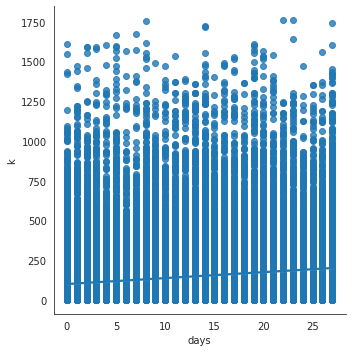

In [199]:
sns.lmplot(data=df_ext, x='days', y='k')

In [171]:
results = enrich_data(train, results, customers)

In [178]:
pt = results.query('len_bought <= 12').pivot_table(
    index='len_bought',
    columns='rel_total',
    values='items_uniq',
    aggfunc='count'
)

pt

rel_total,0,1,2,3,4
len_bought,,,,,
1,21824.0000,816.0000,NaN,NaN,NaN
2,16332.0000,987.0000,68.0000,NaN,NaN
3,9998.0000,690.0000,67.0000,9.0000,NaN
4,6214.0000,513.0000,59.0000,2.0000,1.0000
5,3952.0000,393.0000,38.0000,2.0000,NaN
6,2572.0000,266.0000,42.0000,5.0000,1.0000
7,1724.0000,233.0000,16.0000,5.0000,NaN
8,1220.0000,163.0000,20.0000,1.0000,1.0000
9,789.0000,118.0000,16.0000,3.0000,1.0000


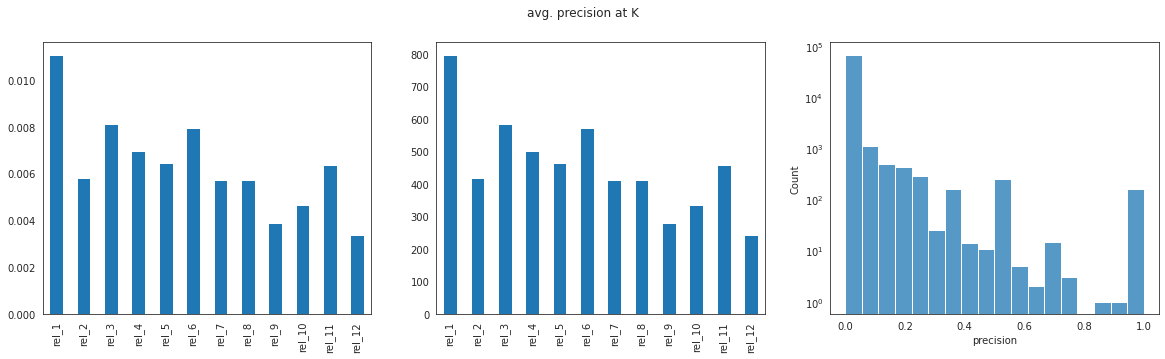

In [173]:
_ = plot_precision_at_k(results)

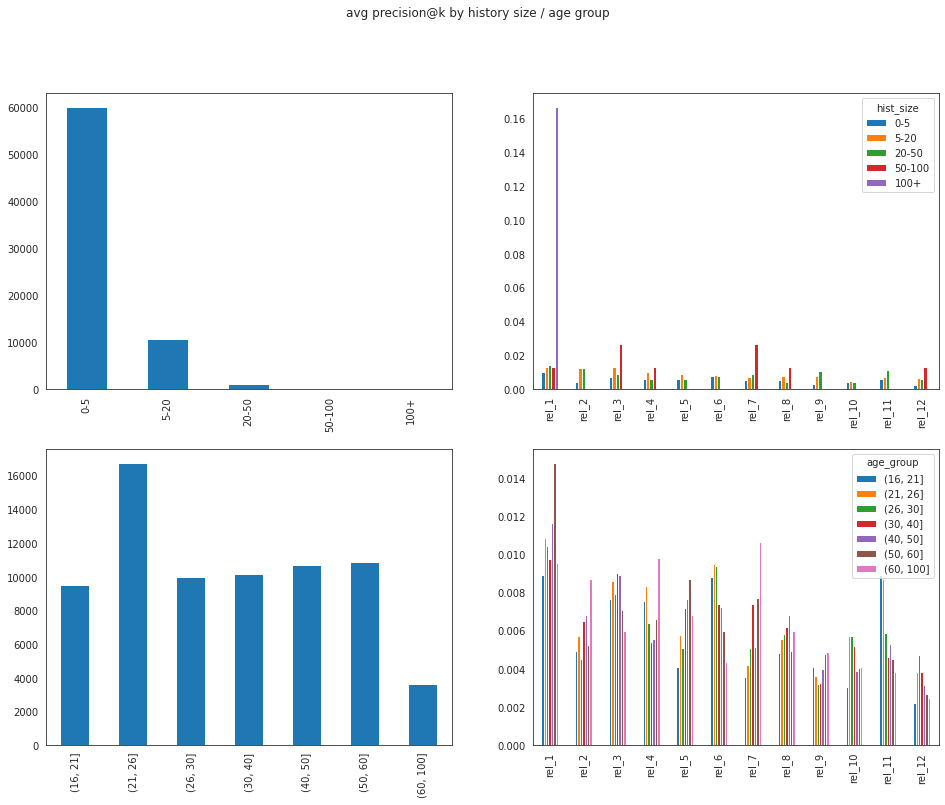

In [175]:
plot_precision_at_k_segments(results);

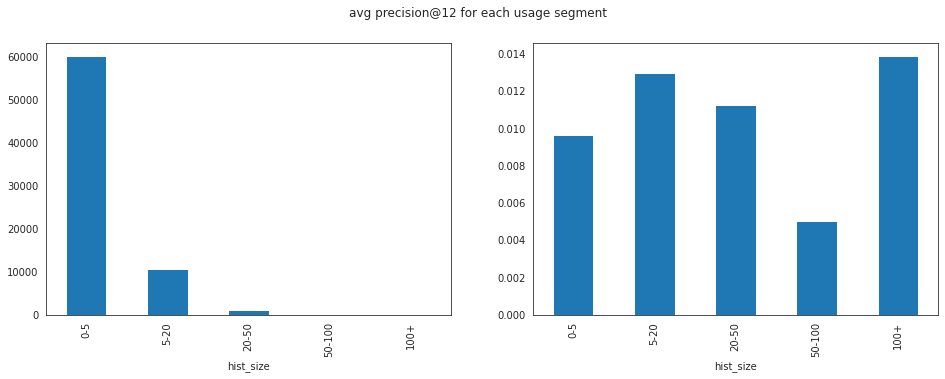

In [176]:
precision_by_usage(results);

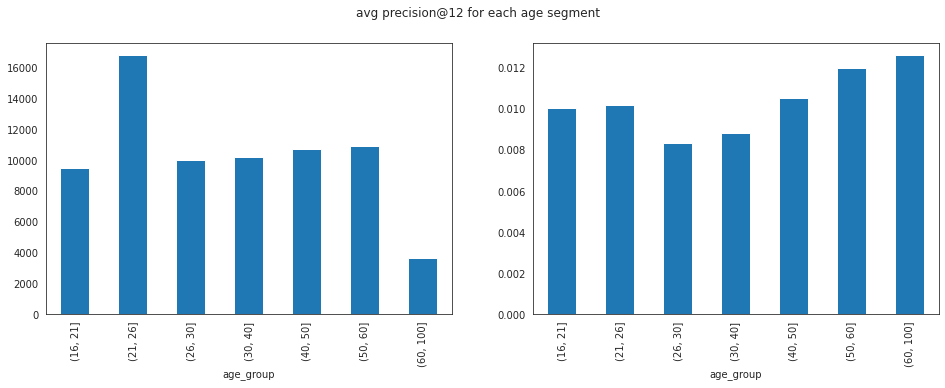

In [177]:
precision_by_age(results);

# make submission

In [117]:
submission = pd.read_csv(data_root / 'sample_submission.csv')

In [271]:
_ = (
    (t['t_dat'] >= '2020-09-01')
)
train = t[_]
print(train.shape)
top12 = (
    train
    .groupby('article_id')
    .agg(total_count=('customer_id', 'count'))
    .sort_values('total_count', ascending=False)[:12].reset_index()['article_id'].tolist()
)
print(top12)
submission = get_knn_recs(train, similarity_df, top12, submission[['customer_id']])

(798269, 5)
['0751471001', '0909370001', '0918522001', '0924243001', '0918292001', '0915526001', '0915529003', '0448509014', '0751471043', '0706016001', '0865799006', '0863595006']
#item-customer pairs (705504, 2)
#similar items (57691313, 8)
#similar items excluding already bought (41059070, 4)


In [272]:
submission['recs'].isna().sum() / submission.shape[0]  # low coverage

0.8710454962900334

In [273]:
submission['prediction'] = submission['prediction'].apply(lambda _: ' '.join(_))

In [274]:
submission.head()

,customer_id,recs,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,"[0858856005, 0779781015, 0762846031, 056860100...",0858856005 0779781015 0762846031 0568601006 05...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,0751471001 0909370001 0918522001 0924243001 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0794321011, 0805000001, 0805000007, 080499201...",0794321011 0805000001 0805000007 0804992014 08...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,0751471001 0909370001 0918522001 0924243001 09...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,NaN,0751471001 0909370001 0918522001 0924243001 09...


In [275]:
submission.shape

(1371980, 3)

In [276]:
submission[['customer_id', 'prediction']].to_csv(data_root / 'output' / 'knn_submission.csv', index=False)